<h2 style="color:Green;">Setup and Loading Packages</h2> Setup and Loading Packages

In [346]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification

import pandas_datareader as pdr

In [347]:
! pip install pandas_datareader

<h2 style="color:Green;">SPY Directional Move</h2><br/>

In [348]:
etLogRet = pd.read_csv('C:/Users/Alan Wei/Downloads/SPY_XLK_IYC.csv')
etLogRet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1086 non-null   object 
 1   SPY     1086 non-null   int64  
 2   XLK     1086 non-null   float64
 3   IYC     1086 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 34.1+ KB


Splitting data into 80% training set and 20% testing set.

In [349]:
VAR_NAMES = ['SPY',  'XLK', 'IYC']
FEATURES = VAR_NAMES[1:]
LABEL = VAR_NAMES[0]
X_train, X_test, y_train, y_test = train_test_split(etLogRet.loc[:, FEATURES], etLogRet.loc[:, LABEL], test_size=0.20, random_state=0)

Using AdaBoostClassifier model for the classification model.

In [350]:
from sklearn.ensemble import AdaBoostClassifier
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 100, 200, 300, 1000],
    'learning_rate':[1, 5, 10]
}
# Create a based model
boosting = AdaBoostClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_
#Create a Boosting Classifier



Fitting 3 folds for each of 15 candidates, totalling 45 fits


{'learning_rate': 1, 'n_estimators': 50}

In [351]:
boosting = AdaBoostClassifier(learning_rate= 1, n_estimators= 200)
#Train the model using the training sets y_pred=clf.predict(X_test)
boosting.fit(X_train,y_train)

# predicted liquidity strengths 
boosting_pred_train = boosting.predict(X_train)
boosting_pred_test = boosting.predict(X_test)

In [352]:
boosting_train_error= np.mean(boosting_pred_train!=y_train)
boosting_test_error= np.mean(boosting_pred_test != y_test)
print('AdaBoost Training Error = %.3f' % boosting_train_error)
print('AdaBoost Testing Error = %.3f' % boosting_test_error)

AdaBoost Training Error = 0.056
AdaBoost Testing Error = 0.115


In [353]:
boosting_train_accuracy= boosting.score(X_train,y_train)
boosting_test_accuracy= boosting.score(X_test,y_test)
print('AdaBoost Training Accuracy Score = %.3f' % boosting_train_accuracy)
print('AdaBoost Testing Accuracy Score = %.3f' % boosting_test_accuracy)

AdaBoost Training Accuracy Score = 0.944
AdaBoost Testing Accuracy Score = 0.885


The above training accuracy scores are really high for a classifier test, showing that it was a good choice for a model.

C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'AdaBoost Confusion Matrix')

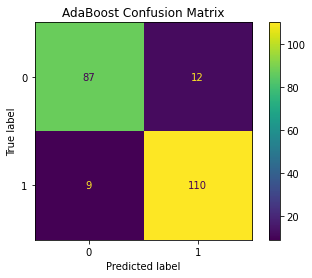

In [354]:
plot_confusion_matrix(rf, X_test, y_test)
plt.title("AdaBoost Confusion Matrix")

In [355]:
# storing f1 score
boosting_f1_score= f1_score(y_test, boosting_pred_test, average='weighted')
print(classification_report(y_test, boosting_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        99
           1       0.87      0.92      0.90       119

    accuracy                           0.89       218
   macro avg       0.89      0.88      0.88       218
weighted avg       0.89      0.89      0.88       218



In [356]:
boosting_pred_test_proba = boosting.predict(X_test)
boosting_auc_score = roc_auc_score(y_test, boosting_pred_test_proba, multi_class='ovr')
print('AdaBoost Classifier: ROC AUC=%.3f' % boosting_auc_score)

AdaBoost Classifier: ROC AUC=0.881


The training accuracy score for the boosting model is higher but the testing accuracy socre is lower, therefore the boosting model is better at fitting the data to a model accurately, and the logistic model is better at finding the proper data points after creating the model.

In [357]:
print('training accuracy score:', boosting.score(X_train,y_train))
print('testing accuracy score:', boosting.score(X_test,y_test))

training accuracy score: 0.9435483870967742
testing accuracy score: 0.8853211009174312


<h2 style="color:Green;">Corporate Bond Ratings Prediction</h2><br/>

Bonds is another financial asset I took a look at, and lots of them have different risks when holding on to them. An example is default risk where the seller decides to not pay back the annual fee. There are also ratings for these bonds, with AAA being the highest.
My goal is to predcit the bond ratings of companies that exhibit different financial properties based on these metric values. 

Here are the financial metrics data was collected and columns that are irrelevant to the financial metrics will be dropped. The remaining columns are features.

In [597]:
bruhMoment = pd.read_csv('C:/Users/Alan Wei/Downloads/corporate_rating.csv')
bruhMoment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                2029 non-null   object 
 1   Rating                              2029 non-null   object 
 2   Name                                2029 non-null   object 
 3   Symbol                              2029 non-null   object 
 4   Rating Agency Name                  2029 non-null   object 
 5   currentRatio                        2029 non-null   float64
 6   quickRatio                          2029 non-null   float64
 7   cashRatio                           2029 non-null   float64
 8   daysOfSalesOutstanding              2029 non-null   float64
 9   netProfitMargin                     2029 non-null   float64
 10  pretaxProfitMargin                  2029 non-null   float64
 11  grossProfitMargin                   2029 no

Explanatory: the features for example: rating agencxy name, current Ratio, quickRatio, etc. Response variable: future company bond rating.

Exploratory Data Analysis to clean the data to only keep the important parts.

In [598]:
LABEL = 'Rating'

bruhMoment.rename(columns = {'Rating Agency Name':'Rating_Agency_Name'}, inplace = True)
FEATURES = bruhMoment.columns

# get the dummies and store it in a variable
dummies = pd.get_dummies(bruhMoment.Symbol)

dummies3 = pd.get_dummies(bruhMoment.Rating_Agency_Name)
# Concatenate the dummies to original dataframe
merged1 = pd.concat([bruhMoment, dummies], axis='columns')  

merged2 = pd.concat([merged1, dummies3], axis='columns')  
merged.head()
# drop the values
bruhMoment1 = merged2.drop(['Name'], axis='columns')
bruhMoment2 = bruhMoment1.drop(['Symbol'], axis='columns')
bruhMoment3 = bruhMoment2.drop(['Rating_Agency_Name'], axis='columns')

# See data info
bruhMoment3.head()

FEATURES = [f for f in FEATURES if f not in ['Rating','Name','Symbol','Rating_Agency_Name','Date']]

bruhMoment3.loc[:, FEATURES] = scale(bruhMoment3.loc[:, FEATURES]) # standardizing indicators
le = LabelEncoder()
le.fit(bruhMoment3.loc[:, LABEL])
bruhMoment3.Rating = le.fit_transform(bruhMoment3.loc[:, LABEL])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'A': 0,
 'AA': 1,
 'AAA': 2,
 'B': 3,
 'BB': 4,
 'BBB': 5,
 'C': 6,
 'CC': 7,
 'CCC': 8,
 'D': 9}

In [610]:
bruhMoment3.head()

FEATURES = FEATURES+dummies.columns.to_list()

FEATURES = FEATURES+dummies3.columns.to_list()

Text(0.5, 0, 'Relative Importance')

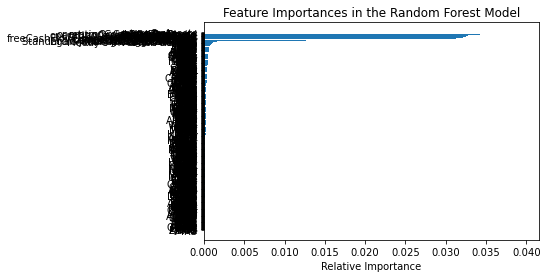

In [600]:
X_train, X_test, y_train, y_test = train_test_split(bruhMoment3.loc[:, FEATURES], bruhMoment3.loc[:, LABEL], test_size=0.2, random_state=0)
from sklearn.ensemble import RandomForestClassifier # importing the random forest module

rf_model = RandomForestClassifier(random_state=0) # define the random forest model

rf_model.fit(X_train, y_train) # fit the random forest model

importances = rf_model.feature_importances_ # get importance

indices = np.argsort(importances) # sort the features' index by their importance scores
plt.title('Feature Importances in the Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')

In [601]:
FEATURES_TO_DROP=[FEATURES[i] for i in indices[importances[indices] < 0.025]]

In [602]:
DATA2 = bruhMoment3.drop(columns=FEATURES_TO_DROP) # drop feature in the original data set
X_train = X_train.drop(columns = FEATURES_TO_DROP) # drop feature in the training data set
X_test = X_test.drop(columns= FEATURES_TO_DROP) # drop feature in the testing data set

FEATURES = [f for f in FEATURES if f not in FEATURES_TO_DROP] 

print(FEATURES)

['currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding', 'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin', 'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed', 'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover', 'debtEquityRatio', 'debtRatio', 'effectiveTaxRate', 'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare', 'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue', 'enterpriseValueMultiple', 'operatingCashFlowPerShare', 'operatingCashFlowSalesRatio', 'payablesTurnover']


I chose to use the BaggingClassifier because the current model has tons of weak learners, and bagging helps all of these 
smaller lesser models come together to help create a working better model.

In [604]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 1000],
    'max_samples':[1, 5, 10],
    'max_features': [1, 2 , 3 , 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
}
# Create a based model
bagging = BaggingClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = bagging, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# fit the grid search to the training data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 525 candidates, totalling 1575 fits


C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'max_features': 17, 'max_samples': 10, 'n_estimators': 1000}

In [605]:
# Creating a Bagging classifier
bagging = BaggingClassifier(max_features= 17, max_samples= 10, n_estimators= 1000)
# fit the bagging on the training data
bagging.fit(X_train, y_train)

# predicted liquidity strengths 
bagging_pred_train = bagging.predict(X_train)
bagging_pred_test = bagging.predict(X_test)

In [606]:
bagging_train_error= np.mean(bagging_pred_train!=y_train)
bagging_test_error= np.mean(bagging_pred_test != y_test)
print('Bagging Training Error = %.3f' % bagging_train_error)
print('Bagging Testing Error = %.3f' % bagging_test_error)

Bagging Training Error = 0.622
Bagging Testing Error = 0.613


In [607]:
bagging_train_accuracy= bagging.score(X_train,y_train)
bagging_test_accuracy= bagging.score(X_test,y_test)
print('Bagging Training Accuracy Score = %.3f' % bagging_train_accuracy)
print('Bagging Testing Accuracy Score = %.3f' % bagging_test_accuracy)

Bagging Training Accuracy Score = 0.378
Bagging Testing Accuracy Score = 0.387


C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Bagging Confusion Matrix')

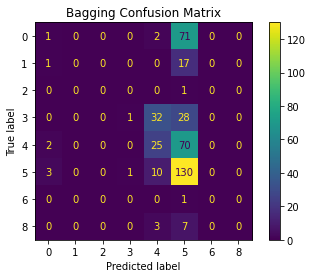

In [608]:
################ OUTPUT THE PERFORMANCE RESULTS HERE #################
plot_confusion_matrix(bagging, X_test, y_test)
plt.title("Bagging Confusion Matrix")





######################################################################

In [609]:
bagging_f1_score= f1_score(y_test, bagging_pred_test, average='weighted')
print(classification_report(y_test, bagging_pred_test))

              precision    recall  f1-score   support

           0       0.14      0.01      0.02        74
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00         1
           3       0.50      0.02      0.03        61
           4       0.35      0.26      0.30        97
           5       0.40      0.90      0.55       144
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        10

    accuracy                           0.39       406
   macro avg       0.17      0.15      0.11       406
weighted avg       0.33      0.39      0.28       406



C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I chose support vector machines as the second model since there is a relatively clear separation between the features, and since there are a lot of features, it is effective in spliting apart the data.

In [612]:
from sklearn import svm
# build SVC model and choose the Radial Basis Function (RBF) kernel function
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, probability=True).fit(X_train, y_train)
# choose the Polynomial kernel function
poly = svm.SVC(kernel='poly', degree=3, C=1, probability=True).fit(X_train, y_train)

# predicted liquidity strengths 
rbf_pred_train = rbf.predict(X_train)
rbf_pred_test = rbf.predict(X_test)
poly_pred_train = poly.predict(X_train)
poly_pred_test = poly.predict(X_test)

In [613]:
rbf_train_error= np.mean(rbf_pred_train!=y_train)
rbf_test_error= np.mean(rbf_pred_test != y_test)
print('SVC (RBF Kernel) Training Error = %.3f' % rbf_train_error)
print('SVC (RBF Kernel) Testing Error = %.3f' % rbf_test_error)
poly_train_error= np.mean(poly_pred_train!=y_train)
poly_test_error= np.mean(poly_pred_test != y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Error = %.3f' % poly_train_error)
print('SVC (3rd-Degree Polynomial Kernel) Testing Error = %.3f' % poly_test_error)

SVC (RBF Kernel) Training Error = 0.650
SVC (RBF Kernel) Testing Error = 0.638
SVC (3rd-Degree Polynomial Kernel) Training Error = 0.650
SVC (3rd-Degree Polynomial Kernel) Testing Error = 0.638


In [614]:
rbf_train_accuracy= rbf.score(X_train,y_train)
rbf_test_accuracy= rbf.score(X_test,y_test)
print('SVC (RBF Kernel) Training Accuracy Score = %.3f' % rbf_train_accuracy)
print('SVC (RBF Kernel) Testing Accuracy Score = %.3f' % rbf_test_accuracy)
poly_train_accuracy= poly.score(X_train,y_train)
poly_test_accuracy= poly.score(X_test,y_test)
print('SVC (3rd-Degree Polynomial Kernel) Training Accuracy Score = %.3f' % poly_train_accuracy)
print('SVC (3rd-Degree Polynomial Kernel) Testing Accuracy Score = %.3f' % poly_test_accuracy)

SVC (RBF Kernel) Training Accuracy Score = 0.350
SVC (RBF Kernel) Testing Accuracy Score = 0.362
SVC (3rd-Degree Polynomial Kernel) Training Accuracy Score = 0.350
SVC (3rd-Degree Polynomial Kernel) Testing Accuracy Score = 0.362


C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SVC (RBF Kernel) Confusion Matrix')

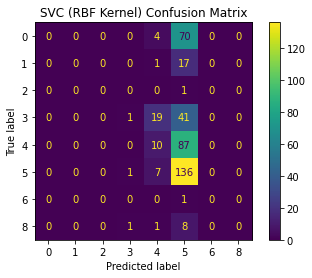

In [615]:
plot_confusion_matrix(rbf, X_test, y_test)
plt.title("SVC (RBF Kernel) Confusion Matrix")

C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SVC (3rd-Degree Polynomial Kernel) Confusion Matrix')

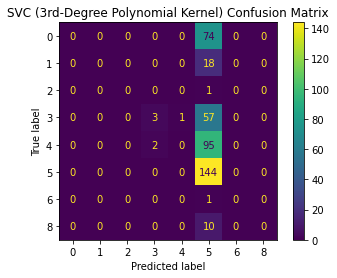

In [616]:
plot_confusion_matrix(poly, X_test, y_test)
plt.title("SVC (3rd-Degree Polynomial Kernel) Confusion Matrix")

In [617]:
rbf_f1_score= f1_score(y_test, rbf_pred_test, average='weighted')
print(classification_report(y_test, rbf_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00         1
           3       0.33      0.02      0.03        61
           4       0.24      0.10      0.14        97
           5       0.38      0.94      0.54       144
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        10

    accuracy                           0.36       406
   macro avg       0.12      0.13      0.09       406
weighted avg       0.24      0.36      0.23       406



C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [620]:
poly_f1_score= f1_score(y_test, poly_pred_test, average='weighted')
print(classification_report(y_test, poly_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00         1
           3       0.60      0.05      0.09        61
           4       0.00      0.00      0.00        97
           5       0.36      1.00      0.53       144
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        10

    accuracy                           0.36       406
   macro avg       0.12      0.13      0.08       406
weighted avg       0.22      0.36      0.20       406



C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alan Wei\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


My model did not perform very well compared to the first part, as the accuracy scores of the models I tested in the second part were usually around .35, which is very low. The first model having a more clear cut way of determining since there were only two features that were considered, rather than 8.

Bond ratings don't affect stock prices directly, but they do affect them indirectly, by investors seeing a bad stock as bad, so less people invest, therefore dropping the price, and vice versa if the bond rating were to increase, the price would also increase.